In [4]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L

In [5]:
hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

omega = 2.0*np.pi*778e3 #Lange
Omegarf = 2.0*np.pi*13e6 #Lange
m = 170.936331517*amutokg
alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)

In [75]:
def psi(g,e):
    return np.array([g, e])

def pulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def dopAndStark(n):       #for 1D!! to make 3d, multiply this by 3                        
    return -2.0*np.pi*nu0*hbar*omega*(n+0.5)/(m*c**2)*(1.0 + alpha*m**2*Omegarf**2*c**2/(h*nu0*e**2*2)) 

def Omega(n,m,eta):
    return np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2)              #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

In [138]:
def thermPulse(psi0, t, Omega0, delPrime, eta): #1-dimensional
    Ncut = shape(psi0)[0]
    state = np.zeros([Ncut,2],dtype=np.complex_)
    for n in range(Ncut):
        #state[n] = pulse(t, Omega0*Omega(n,0,eta), delPrime+dopAndStark(n), 0.0, 0.0)@psi0[n]
        state[n] = pulse(t, Omega0*Omega(n,0,eta), delPrime, 0.0, 0.0)@psi0[n]
    return state

def rhoee(psi, nbar):
    result = 0.0
    Ncut = shape(psi0)[0]
    for n in range(Ncut):
        #print(prob(n,nbar))
        #print((abs(psi0[n][1]))**2.0)
        result += prob(n,nbar)*(abs(psi[n][1]))**2.0
    return result

In [143]:
#def RamseyErrSig(deld, psi0, t1, T, t2, delPrime, Omega0, eta, nbar0, nbarf, Ncut, delExc):
#    delp1 = delPrime
#    delp2 = delPrime + dopAndStark(nbarf) - dopAndStark(nbar0)
#    phi = 0.5*(dopAndStark(nbarf)+dopAndStark(nbar0))*T + delExc*T
#    freeEvo = pulse(T, 0.0, deld, 0.0, phi)
#    pi2PhaseInjP = pulse(0.0, 0.0, 0.0, 0.0, np.pi/2.0)
#    pi2PhaseInjM = pulse(0.0, 0.0, 0.0, 0.0, -np.pi/2.0)
#    intState = thermPulse(psi0, t1, Omega0, delp1, eta, nbar0, Ncut)
#    resultP = thermPulse(freeEvo@pi2PhaseInjP@intState, t2, Omega0, delp2, eta, nbarf, Ncut)
#    resultM = thermPulse(freeEvo@pi2PhaseInjM@intState, t2, Omega0, delp2, eta, nbarf, Ncut)
#    return rhoee(resultP) - rhoee(resultM)

def ramsey(deld, psi0, t1, T, t2, delPrime, Omega0, eta, nbardot):
    Ncut = shape(psi0)[0]
    state = thermPulse(psi0, t1, Omega0, delPrime, eta)
    for n in range(Ncut):
        phi = 0.5*(dopAndStark(n)+dopAndStark(n+nbardot*T))*T
        state[n] = pulse(T, 0.0, deld, 0.0, phi)@state[n]
    return thermPulse(state, t2, Omega0, delPrime, eta)

def RamseyErrSig(deld, psi0, t1, T, t2, delPrime, Omega0, eta, nbarf):
    Ncut = shape(psi0)[0]
    nbardot = nbarf/(t1+T+t2)
    state = thermPulse(psi0, t1, Omega0, delPrime, eta)
    stateP = np.zeros([Ncut,2],dtype=np.complex_)
    stateM = np.zeros([Ncut,2],dtype=np.complex_)
    for n in range(Ncut):
        #phi =0.0
        phi = 0.5*(dopAndStark(n)+dopAndStark(n+nbardot*T))*T
        stateP[n] = pulse(T, 0.0, deld, 0.0, phi+np.pi/2.0)@state[n]
        stateM[n] = pulse(T, 0.0, deld, 0.0, phi-np.pi/2.0)@state[n]
    stateP = thermPulse(stateP, t2, Omega0, delPrime, eta)
    stateM = thermPulse(stateM, t2, Omega0, delPrime, eta)
    return rhoee(stateP,nbarf) - rhoee(stateM,nbarf)

def HRErrSig(deld, psi0, t1, T, Delta, Omega0, eta, nbarf):
    delPrime = deld-Delta
    Ncut = shape(psi0)[0]
    t3 = 2.0*t1
    t4 = t1
    nbardot = nbarf/(t1+T+t3+t4)
    state = thermPulse(psi0, t1, Omega0, delPrime, eta)
    stateP = np.zeros([Ncut,2],dtype=np.complex_)
    stateM = np.zeros([Ncut,2],dtype=np.complex_)
    for n in range(Ncut):
        phi =0.0
        #phi = 0.5*(dopAndStark(n)+dopAndStark(n+nbardot*T))*T
        stateP[n] = pulse(T, 0.0, deld, 0.0, phi+np.pi/2.0)@state[n]
        stateM[n] = pulse(T, 0.0, deld, 0.0, phi-np.pi/2.0)@state[n]
    stateP = thermPulse(thermPulse(stateP, t3, -Omega0, delPrime, eta), t4, Omega0, delPrime, eta)
    stateM = thermPulse(thermPulse(stateM, t3, -Omega0, delPrime, eta), t4, Omega0, delPrime, eta)
    return rhoee(stateP,nbarf) - rhoee(stateM,nbarf)

In [56]:
Ncut = 101
psi0 = np.zeros([Ncut,2],dtype=np.complex_)
for n in range(Ncut):
    psi0[n] = psi(1.0+0.0j,0.0+0.0j)

In [80]:
tpts = 200
ts = np.linspace(0,320e-3, tpts)
Omega0 = np.pi/(2.0*20e-3)
delPrime = 0.0*2.0*np.pi
eta = 0.05
rhoee1s = np.zeros(tpts)
rhoee2s = np.zeros(tpts)
nbar = 10.0
nbars = np.linspace(10.0, 15.0, tpts)

for ii in range(tpts):
    state = thermPulse(psi0, ts[ii], Omega0, delPrime, eta)
    rhoee1s[ii] = rhoee(state, nbar)
    rhoee2s[ii] = rhoee(state, nbars[ii])

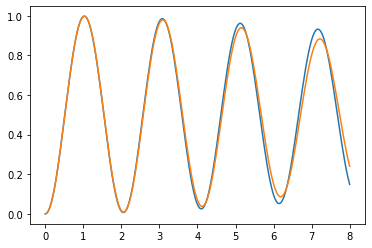

In [82]:
plt.plot(ts*Omega0/np.pi, rhoee1s)
plt.plot(ts*Omega0/np.pi, rhoee2s)

In [98]:
Ncut = 101
psi0 = np.zeros([Ncut,2],dtype=np.complex_)
for n in range(Ncut):
    psi0[n] = psi(1.0+0.0j,0.0+0.0j)
    
t1 = 20.0e-3
t2 = t1
T = 500e-3
Omega0 = np.pi/(2.0*t1)
delpts = 10
delds = np.linspace(-0.01*2.0*np.pi, 0.01*2.0*np.pi, delpts)
delPrime = 0.01*2.0*np.pi
nbardot = 100.0
nbarf = nbardot*(t1+t2+T)
eta = 0.05
errSigPts = np.zeros(delpts)

for ii in range(delpts):
    errSigPts[ii] = RamseyErrSig(delds[ii], psi0, t1, T, t2, delPrime, Omega0, eta, nbarf)

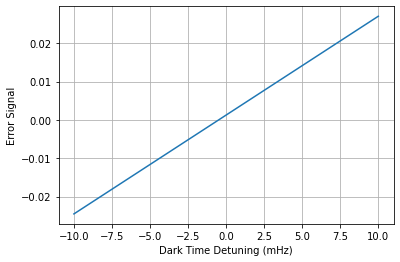

In [99]:
plt.plot(delds/(2.0*np.pi)*1e3, errSigPts)
plt.grid()
plt.xlabel("Dark Time Detuning (mHz)")
plt.ylabel("Error Signal")
plt.show()

In [123]:
Ncut = 101
psi0 = np.zeros([Ncut,2],dtype=np.complex_)
for n in range(Ncut):
    psi0[n] = psi(1.0+0.0j,0.0+0.0j)
    
t1 = 20.0e-3
t2 = t1
T = 500e-3
Omega0 = np.pi/(2.0*t1)
nbarf = 0.0
eta = 0.0

pts = 10
delPrimes = np.linspace(-0.01*2.0*np.pi, 0.01*2.0*np.pi, pts)
shifts = np.zeros(pts)
shift1s = np.zeros(pts)

tol = 1.0e-11
x0 = -0.1
x1 = 0.1
guessTol = 0.1

for ii in range(pts):
    print(delPrimes[ii])
    shifts[ii] = (1.0/(2.0*np.pi))*sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, t2, delPrimes[ii], Omega0, eta, nbarf), bracket=[x0,x1], xtol = tol).root
    shift1s[ii] = (1.0/(2.0*np.pi))*sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, 3.0*t2, delPrimes[ii], Omega0, eta, nbarf), bracket=[x0,x1], xtol = tol).root
    print(shifts[ii])
    x0 = shifts[ii]*(2.0*np.pi) - guessTol
    x1 = shifts[ii]*(2.0*np.pi) + guessTol
    #print(x0,x1)

-0.06283185307179587
0.0005092958022696374
-0.04886921905584123
0.0003961189621217569
-0.0349065850398866
0.00028294211837316506
-0.020943951023931956
0.0001697652720527021
-0.006981317007977321
5.658842418890398e-05
0.006981317007977314
-5.658842418902821e-05
0.020943951023931956
-0.00016976527205272182
0.034906585039886584
-0.00028294211837315254
0.048869219055841226
-0.00039611896212173785
0.06283185307179587
-0.0005092958022696477


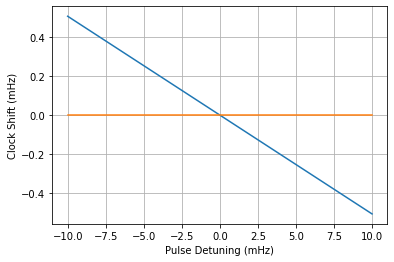

In [125]:
#Notice that the slope matches the correct one, 2/(Omega0*T)
#Also, if you comment out the RS curve, you'll see that the HRS one is cubic as expected
plt.plot(delPrimes/(2.0*np.pi)*1e3, shifts*1e3, label="RS")
plt.plot(delPrimes/(2.0*np.pi)*1e3, shift1s*1e3, label="HRS")
plt.xlabel("Pulse Detuning (mHz)")
plt.ylabel("Clock Shift (mHz)")
plt.grid()
plt.show()

In [133]:
Ncut = 201
psi0 = np.zeros([Ncut,2],dtype=np.complex_)
for n in range(Ncut):
    psi0[n] = psi(1.0+0.0j,0.0+0.0j)
    
t1 = 20.0e-3
t2 = t1
T = 500e-3
Omega0 = np.pi/(2.0*t1)
nbarf = 40.0
eta = 0.05
delPrime = 0.0*2.0*np.pi

pts = 5
nbarfs = np.linspace(0.0, 40.0, pts)
shifts = np.zeros(pts)
shifts1 = np.zeros(pts)

tol = 1.0e-11
x0 = -0.1
x1 = 0.1
guessTol = 0.1

for ii in range(pts):
    print(nbarfs[ii])
    #shifts[ii] = (1.0/(2.0*np.pi))*sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, t2, delPrime, Omega0, eta, nbarfs[ii]), bracket=[x0,x1], xtol = tol).root
    shifts1[ii] = (1.0/(2.0*np.pi))*sp.optimize.root_scalar(RamseyErrSig, args=(psi0, t1, T, t2*3.0, delPrime, Omega0, eta, nbarfs[ii]), bracket=[x0,x1], xtol = tol).root
    #print(shifts[ii])
    x0 = shifts[ii]*(2.0*np.pi) - guessTol
    x1 = shifts[ii]*(2.0*np.pi) + guessTol
    #print(x0,x1)

0.0
10.0
20.0
30.0
40.0


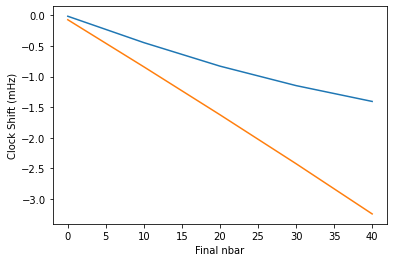

In [137]:
#plt.plot(nbarfs, shifts*1e3, label="RS")
plt.plot(nbarfs, shifts1*1e3, label="HRS")
plt.plot(nbarfs, 1e3*np.array([-7.26022535e-05, -8.41610515e-04, -1.62399530e-03, -2.42310390e-03,-3.24313556e-03]))
plt.xlabel("Final nbar")
plt.ylabel("Clock Shift (mHz)")
plt.show()

In [135]:
shifts1

array([-1.54066767e-05, -4.46262271e-04, -8.30204457e-04, -1.14790990e-03,
       -1.40647534e-03])

Next to do: 
Compare this curve to the old function. 
See if this method holds up to chopping the pulses (it absolutely will)
Introduce heating during the pulses.

In [144]:
Ncut = 270
psi0 = np.zeros([Ncut,2],dtype=np.complex_)
for n in range(Ncut):
    psi0[n] = psi(1.0+0.0j,0.0+0.0j)

Omega0 = 10.0*2.0*np.pi #Hz
t1 = np.pi/(2.0*Omega0)
T = np.pi*2.0/Omega0

nbarf = 20.0+30*0.2
eta = 0.1

pts = 5
#nbarfs = np.linspace(0.0, 40.0, pts)
Deltas = np.linspace(0.0, 0.1*Omega0, 5)
shifts = np.zeros(pts)
shifts1 = np.zeros(pts)

tol = 1.0e-11
x0 = -0.1
x1 = 0.1
guessTol = 0.1

for ii in range(pts):
    print(nbarfs[ii])
    shifts[ii] = (1.0/(2.0*np.pi))*sp.optimize.root_scalar(HRErrSig, args=(psi0, t1, T, Deltas[ii], Omega0, eta, nbarf), bracket=[x0,x1], xtol = tol).root
    print(shifts[ii])
    x0 = shifts[ii]*(2.0*np.pi) - guessTol
    x1 = shifts[ii]*(2.0*np.pi) + guessTol
    #print(x0,x1)

0.0
0.0
10.0
0.0001486234215435426
20.0
0.001175835323342803
30.0
0.003897369701245053
40.0
0.009015663904264287


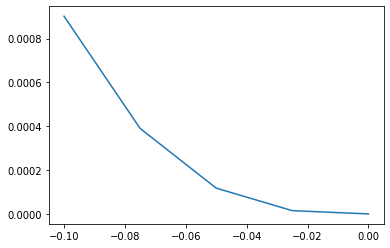

In [147]:
plt.plot(-Deltas/Omega0, shifts*(2.0*np.pi)/Omega0)

In [141]:
t1*4+T

0.2

In [146]:
2.0*np.pi*(shifts[1]-shifts[0])/(Deltas[1]-Deltas[0])

0.0005944936861741704

In [148]:
Ncut = 201
psi0 = np.zeros([Ncut,2],dtype=np.complex_)
t = 20e-3
Omega0 = np.pi/(2.0*t)
eta = 0.05
delPrime = 0.0
for n in range(Ncut):
    psi0[n] = psi(1.0+0.0j,0.0+0.0j)
psi1 = thermPulse(psi0, t, Omega0, delPrime, eta)
psi2 = thermPulse(thermPulse(psi0, t/2.0, Omega0, delPrime, eta), t/2.0, Omega0, delPrime, eta)

In [150]:
rhoee(psi1,2.0)

0.49510701829026804

In [151]:
rhoee(psi2,2.0)

0.4951070182902681